## Linear Regression Tutorial, Part 2: Multiple Linear Regression

RJ Nowling

In part 1 of this Linear Regression tutorial, we built a simple linear regression model using the squared footage of real eastate to predict the prices of transactions.  when we compared the simple model to a base model that used only an average price, we saw the root-mean square error decrease from by about \$20,000.  In part 2 of this tutorial, we're going to build a multiple linear regression model that incorporates all of the numerical variables.

We'll start by importing the various libraries we'll need.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

%matplotlib inline

### Load and Clean Data

Before we can build any models, we need to import the data and clean it by converting types as necessary.

In [2]:
df = pd.read_csv("Sacramentorealestatetransactions.csv")

In [3]:
df.head()

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768


In [4]:
df.dtypes

street        object
city          object
zip            int64
state         object
beds           int64
baths          int64
sq__ft         int64
type          object
sale_date     object
price          int64
latitude     float64
longitude    float64
dtype: object

For this part of the tutorial, we're only going to use the numerical variables, so we don't need to transform anything right now.  Let's check if there are any records missing a value for this field.

In [5]:
numerical_columns = ["beds", "baths", "sq__ft", "latitude", "longitude"]
for col_name in numerical_columns:
    print(col_name, df[col_name].isnull().sum())

beds 0
baths 0
sq__ft 0
latitude 0
longitude 0


The data doesn't appear to have any missing data.  Let's check the histogram just to make sure.

C:\Users\nowling\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


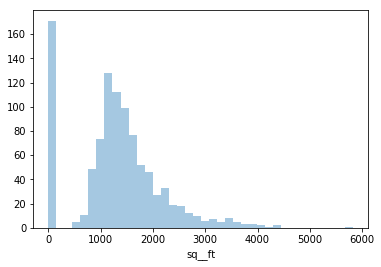

In [6]:
sns.distplot(df["sq__ft"], kde=False)

C:\Users\nowling\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


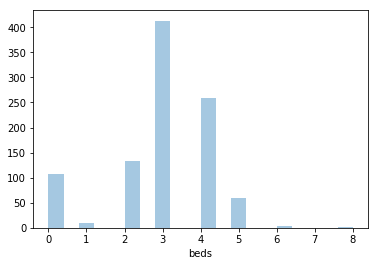

In [7]:
sns.distplot(df["beds"], kde=False)

C:\Users\nowling\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


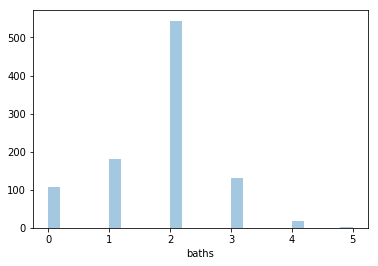

In [8]:
sns.distplot(df["baths"], kde=False)

C:\Users\nowling\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


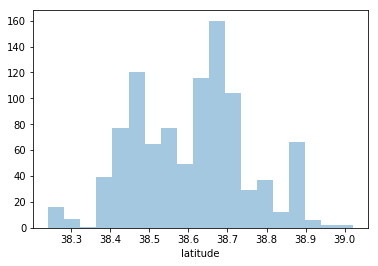

In [9]:
sns.distplot(df["latitude"], kde=False)

C:\Users\nowling\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


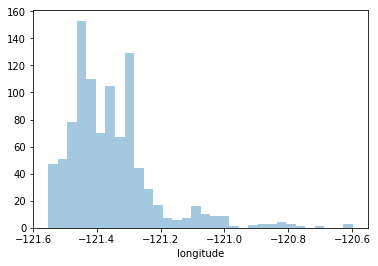

In [10]:
sns.distplot(df["longitude"], kde=False)

Latitude and longitude don't seem to have any zero values. Some properties have 0 bedrooms and bathrooms but that may not be abnormal since our data set includes commercial real estate as well as residential real estate.  We're not gonna handle this now -- we'll handle it later on.

## Experimental Setup

Our goal is to build a predictive model.  Predictive models are applied to data where the outcome variable is unknown.  To accurately evaluate our model, we need to see how it performs on unseen data.  We simulate this by dividing our data set into two groups: a training set (75%) and a testing set (25%).  For this linear regression model, we'll use a simple scheme of random assignment.  

In [11]:
df_train, df_test = train_test_split(df)
print(df.shape[0], df_train.shape[0], df_test.shape[0])

985 738 247


## Multiple Linear Regression Model

Now, we will fit a multiple linear regression model.  A multiple linear regression model has a multiple variables in it:

$$
\hat{y} = \beta_0 + \beta_1 x_1 + \cdots + \beta_p x_p
$$

where $\hat{y}$ is the predicted price, $x_1, x_2, \cdots, x_p$ will be our features, and $\beta_0, \beta_1, \cdots, \beta_p$ are coefficients fit by the model based on the data.

Let's define a utility function to make it easier to build feature matrices.  The utility function will handle imputing and scaling the numerical variables for us.  The utility function will also incorporate categorical variables, but we won't get to those quite yet.

In [12]:
def create_feature_matrices(df_train, df_test, selected_columns, dummy_columns=None):
    """
    Creates feature matrices for the training and testing sets from the given dataframes.
    The feature matrices are built from the columns given in selected columns.
    """
    
    if dummy_columns is None:
        dummy_columns = dict()
    
    # keep track of numerical features
    numerical_trial_columns = []
    
    # keep track of dummy features for categorical variables
    categorical_trial_columns = []
    
    # build feature lists
    for col_name in selected_columns:
        if col_name in dummy_columns:
            categorical_trial_columns.extend(dummy_columns[col_name])
        else:
            numerical_trial_columns.append(col_name)

    # transform numerical features
    if len(numerical_trial_columns) > 0:
        X_train_numerical = df_train[numerical_trial_columns].astype("float64").values
        X_test_numerical = df_test[numerical_trial_columns].astype("float64").values
    
        imputer = Imputer(missing_values=0)
        X_train_numerical = imputer.fit_transform(X_train_numerical)
        X_test_numerical = imputer.transform(X_test_numerical)
    
        scaler = StandardScaler()
        X_train_numerical = scaler.fit_transform(X_train_numerical)
        X_test_numerical = scaler.transform(X_test_numerical)
    
    # select categorical features
    if len(categorical_trial_columns) > 0:
        X_train_categorical = df_train[categorical_trial_columns].astype("float64").values
        X_test_categorical = df_test[categorical_trial_columns].astype("float64").values
    
    # concatenate feature matrices
    if len(numerical_trial_columns) > 0 and len(categorical_trial_columns) > 0:
        X_train = np.hstack([X_train_numerical, X_train_categorical])
        X_test = np.hstack([X_test_numerical, X_test_categorical])
    elif len(numerical_trial_columns) > 0:
        X_train = X_train_numerical
        X_test = X_test_numerical
    else:
        X_train = X_train_categorical
        X_test = X_test_categorical
        
    return X_train, X_test

We now create the vectors for our response variables and apply the utility function to create our feature matrices.

In [13]:
y_train = df_train["price"].values
y_test = df_test["price"].values

X_train, X_test = create_feature_matrices(df_train, df_test, numerical_columns)

print(y_train.shape, y_test.shape, X_train.shape, X_train.shape)

(738,) (247,) (738, 5) (738, 5)


With the response vectors and feature matrices, we can build a multiple linear regression model and then calculate the model error on the testing set.

In [14]:
lr = SGDRegressor(max_iter=5000)
lr.fit(X_train, y_train)
pred_prices_test = lr.predict(X_test)

mse = mean_squared_error(y_test, pred_prices_test)
rmse = np.sqrt(mse)
print()
print("Model MSE:", mse)
print("Model RMSE:", rmse)


Model MSE: 12502979133.546888
Model RMSE: 111816.72117150854


Text(0,0.5,'Predicted Price')

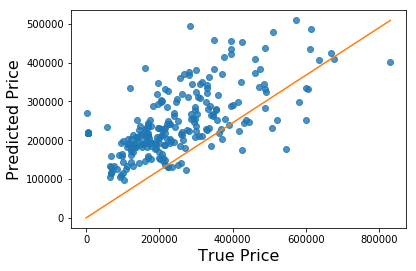

In [15]:
sns.regplot(x=y_test, y=pred_prices_test, fit_reg=False)
plt.plot([0, np.max(y_test)], [0, np.max(pred_prices_test)])
plt.xlabel("True Price", fontsize=16)
plt.ylabel("Predicted Price", fontsize=16)

Compared to our simple linear regression model using only the squared footage, we see more correlation between the true prices and predicted prices. 

## Variable Selection

In [16]:
def sort_columns(df_train, df_test, y_train, y_test, all_columns):
    column_rmses = []

    for col_name in all_columns:
        X_train, X_test = create_feature_matrices(df_train,
                                                 df_test,
                                                 [col_name])
    
        simple_lr = SGDRegressor(max_iter=5000)
        simple_lr.fit(X_train, y_train)
        pred_prices_simple_test = simple_lr.predict(X_test)
        simple_mse = mean_squared_error(y_test, pred_prices_simple_test)
        simple_rmse = np.sqrt(simple_mse)
        print()
        print(col_name + " Model MSE:", simple_mse)
        print(col_name + " Model RMSE:", simple_rmse)
        column_rmses.append((simple_rmse, col_name))
    
    column_rmses.sort(key=lambda p: p[0])
    sorted_columns = [col_name for _, col_name in column_rmses]
    print()
    print("Sorted columns:" + str(sorted_columns))
    
    return sorted_columns

In [17]:
sorted_columns = sort_columns(df_train, df_test, y_train, y_test, numerical_columns)


beds Model MSE: 17295948317.978592
beds Model RMSE: 131514.06129375898

baths Model MSE: 16277050123.359692
baths Model RMSE: 127581.54303565893

sq__ft Model MSE: 14544169852.217216
sq__ft Model RMSE: 120599.21165669872

latitude Model MSE: 21364129944.329884
latitude Model RMSE: 146164.73563869597

longitude Model MSE: 19057577885.15069
longitude Model RMSE: 138049.18647044135

Sorted columns:['sq__ft', 'baths', 'beds', 'longitude', 'latitude']


In [18]:
def select_features(df_train, df_test, y_train, y_test, sorted_columns, dummy_columns=None):
    lr = SGDRegressor(max_iter=5000)
    
    train_zeros = np.zeros((y_train.shape[0], 1))
    test_zeros = np.zeros((y_test.shape[0], 1))
    lr.fit(train_zeros, y_train)
    pred_y_test = lr.predict(test_zeros)
    
    null_mse = mean_squared_error(y_test, pred_y_test)
    null_rmse = np.sqrt(null_mse)
    
    base_model_columns = []
    base_rmse = null_rmse
    base_mse = null_mse

    print("Base Model MSE:", base_mse)
    print("Base Model RMSE:", base_rmse)
    print()

    for col_name in sorted_columns:
        # track all column names
        trial_columns = base_model_columns[:]
        trial_columns.append(col_name)

        X_train, X_test = create_feature_matrices(df_train,
                                                  df_test,
                                                  trial_columns,
                                                  dummy_columns=dummy_columns)
    
        lr = SGDRegressor(max_iter=5000)
        lr.fit(X_train, y_train)
        pred_y_test = lr.predict(X_test)
        trial_mse = mean_squared_error(y_test, pred_y_test)
        trial_rmse = np.sqrt(trial_mse)
        print()
        print(str(trial_columns) + " Model MSE:", trial_mse)
        print(str(trial_columns) + " Model RMSE:", trial_rmse)
    
        if trial_rmse < base_rmse:
            print("Updating base model")
            base_rmse = trial_rmse
            base_mse = trial_mse
            base_model_columns = trial_columns
        
        print()
        print("Base Model MSE:", base_mse)
        print("Base Model RMSE:", base_rmse)
        print()
    
    print("Our chosen columns are: " + str(base_model_columns))
    return base_model_columns

In [19]:
selected_columns = select_features(df_train, df_test, y_train, y_test, sorted_columns)

Base Model MSE: 21372413234.039253
Base Model RMSE: 146193.06835154412


['sq__ft'] Model MSE: 14549038972.06379
['sq__ft'] Model RMSE: 120619.3971634073
Updating base model

Base Model MSE: 14549038972.06379
Base Model RMSE: 120619.3971634073


['sq__ft', 'baths'] Model MSE: 14068088023.888708
['sq__ft', 'baths'] Model RMSE: 118608.97109362642
Updating base model

Base Model MSE: 14068088023.888708
Base Model RMSE: 118608.97109362642


['sq__ft', 'baths', 'beds'] Model MSE: 14068863176.17611
['sq__ft', 'baths', 'beds'] Model RMSE: 118612.23872845546

Base Model MSE: 14068088023.888708
Base Model RMSE: 118608.97109362642


['sq__ft', 'baths', 'longitude'] Model MSE: 12706665057.381838
['sq__ft', 'baths', 'longitude'] Model RMSE: 112723.84422730551
Updating base model

Base Model MSE: 12706665057.381838
Base Model RMSE: 112723.84422730551


['sq__ft', 'baths', 'longitude', 'latitude'] Model MSE: 12521651098.245872
['sq__ft', 'baths', 'longitude', 'latitude'] Model RMSE: 111900.183638124

In [20]:
X_train, X_test = create_feature_matrices(df_train, df_test, selected_columns)

print(X_train.shape, X_test.shape)

lr = SGDRegressor(max_iter=5000)
lr.fit(X_train, y_train)
pred_prices_test = lr.predict(X_test)

mse = mean_squared_error(y_test, pred_prices_test)
rmse = np.sqrt(mse)
print()
print("Model MSE:", mse)
print("Model RMSE:", rmse)

(738, 4) (247, 4)

Model MSE: 12517779040.976194
Model RMSE: 111882.88091113936


Text(0,0.5,'Predicted Price')

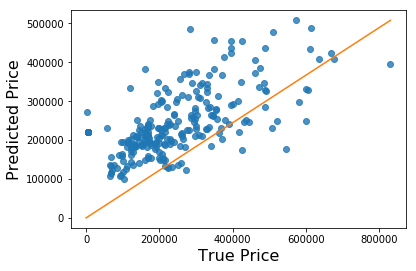

In [21]:
sns.regplot(x=y_test, y=pred_prices_test, fit_reg=False)
plt.plot([0, np.max(y_test)], [0, np.max(pred_prices_test)])
plt.xlabel("True Price", fontsize=16)
plt.ylabel("Predicted Price", fontsize=16)